In [ ]:
pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.7 MB/s eta 0:00:00


In [ ]:
pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 27.0 MB/s eta 0:00:00


In [ ]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qiskit.visualization import plot_bloch_vector, plot_histogram
import matplotlib.pyplot as plt
import numpy as np

## Circuito para generar entrelazamiento

In [ ]:
# 1. Crear un circuito cuántico con 2 qubits y 2 bits clásicos
qc = QuantumCircuit(2, 2)

# 2. Aplicar la puerta Hadamard en el primer qubit para generar superposición
qc.h(0)

# 3. Aplicar la puerta CNOT con control en el qubit 0 y objetivo en el qubit 1 para crear entrelazamiento
qc.cx(0, 1)

# Barrera para separar mediciones.
qc.barrier()

# 4. Medir ambos qubits y almacenar el resultado en los bits clásicos correspondientes
qc.measure([0, 1], [0, 1])

# 5. Ejecutar el circuito usando el método actualizado run() del simulador AerSimulator
simulator = AerSimulator()
job = simulator.run(qc, shots=1024)
result = job.result()
counts = result.get_counts()

print("Resultados de la medición:", counts)

# 6. Dibujar el circuito (opción de salida 'text' o 'mpl')
print(qc.draw(output='text'))

# Si deseas ver el dibujo gráfico, descomenta las siguientes líneas:
# qc.draw(output='mpl')
# plt.show()

Resultados de la medición: {'11': 503, '00': 521}
     ┌───┐      ░ ┌─┐   
q_0: ┤ H ├──■───░─┤M├───
     └───┘┌─┴─┐ ░ └╥┘┌─┐
q_1: ─────┤ X ├─░──╫─┤M├
          └───┘ ░  ║ └╥┘
c: 2/══════════════╩══╩═
                   0  1 


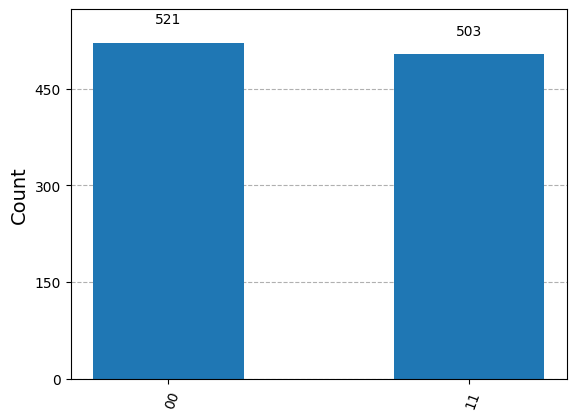

In [ ]:
plot_histogram(counts)

## Interpretación geometrica del entrelazamiento

In [ ]:
def dm_to_bloch_vector(dm):
    """
    Convierte una matriz densidad 2x2 (en numpy) a su Bloch vector [rx, ry, rz].
    dm es un array complejo 2x2.
    """
    r00 = dm[0, 0]
    r11 = dm[1, 1]
    r01 = dm[0, 1]

    rx = 2.0 * np.real(r01)
    ry = 2.0 * np.imag(r01)
    rz = np.real(r00 - r11)
    return np.array([rx, ry, rz], dtype=float)

In [ ]:
# --------------------------------------------------
# 1) Construir el circuito en dos pasos:
#    (A) Antes de la CNOT
#    (B) Después de la CNOT
# --------------------------------------------------

# Creamos un circuito de 2 qubits
qc = QuantumCircuit(2, name="entanglement_demo")

# Paso A: preparar qubit0 en |+> (base X), qubit1 en |0> (base Z)
qc.h(0)          # Qubit 0 -> (|0> + |1>)/sqrt(2)
# (qubit1 ya está en |0> de forma natural)

# Extraemos el statevector en este punto "antes de la CNOT"
qc_A = qc.copy()  # copia del circuito antes de la CNOT
sv_A = Statevector.from_instruction(qc_A)
dm_A = DensityMatrix(sv_A)  # densidad global antes de la CNOT

# Trazas parciales: densidad reducida para cada qubit
dm_A0 = partial_trace(dm_A, [1])  # traza sobre qubit1 => qubit0
dm_A1 = partial_trace(dm_A, [0])  # traza sobre qubit0 => qubit1

# Paso B: aplicamos la CNOT (control=0, target=1)
qc.cx(0, 1)

# Extraemos el statevector tras la CNOT
sv_B = Statevector.from_instruction(qc)
dm_B = DensityMatrix(sv_B)

# Trazas parciales tras la CNOT
dm_B0 = partial_trace(dm_B, [1])  # qubit0
dm_B1 = partial_trace(dm_B, [0])  # qubit1

# --------------------------------------------------
# 2) Cálculo de vectores de Bloch para cada qubit
#    (antes y después de la CNOT)
# --------------------------------------------------
bvec_A0 = dm_to_bloch_vector(dm_A0.data)
bvec_A1 = dm_to_bloch_vector(dm_A1.data)
bvec_B0 = dm_to_bloch_vector(dm_B0.data)
bvec_B1 = dm_to_bloch_vector(dm_B1.data)

print("=== Antes de la CNOT ===")
print(" Bloch vector qubit0:", bvec_A0)
print(" Bloch vector qubit1:", bvec_A1)

print("\n=== Después de la CNOT ===")
print(" Bloch vector qubit0:", bvec_B0)
print(" Bloch vector qubit1:", bvec_B1)

=== Antes de la CNOT ===
 Bloch vector qubit0: [1. 0. 0.]
 Bloch vector qubit1: [0. 0. 1.]

=== Después de la CNOT ===
 Bloch vector qubit0: [0. 0. 0.]
 Bloch vector qubit1: [0. 0. 0.]


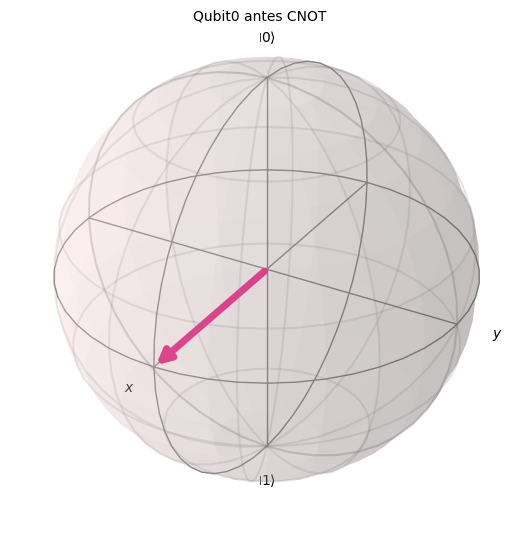

In [ ]:
# --------------------------------------------------
# 3) Graficar las esferas de Bloch
# --------------------------------------------------
# Opción simple: mostramos cada vector en una ventana distinta.
# - bvec_A0: qubit0 antes CNOT
# - bvec_A1: qubit1 antes CNOT
# - bvec_B0: qubit0 después CNOT
# - bvec_B1: qubit1 después CNOT

plot_bloch_vector(bvec_A0, title="Qubit0 antes CNOT")

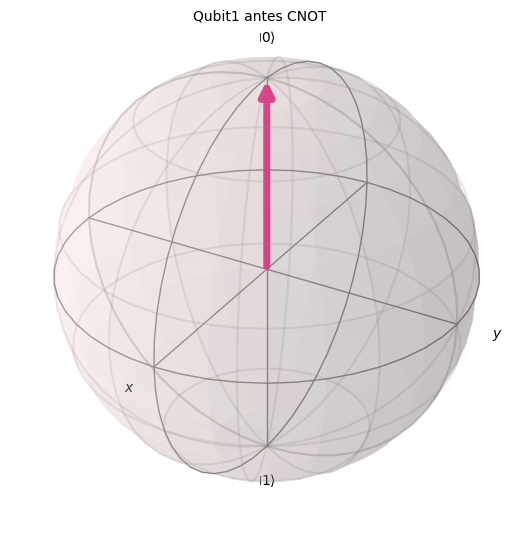

In [ ]:
plot_bloch_vector(bvec_A1, title="Qubit1 antes CNOT")

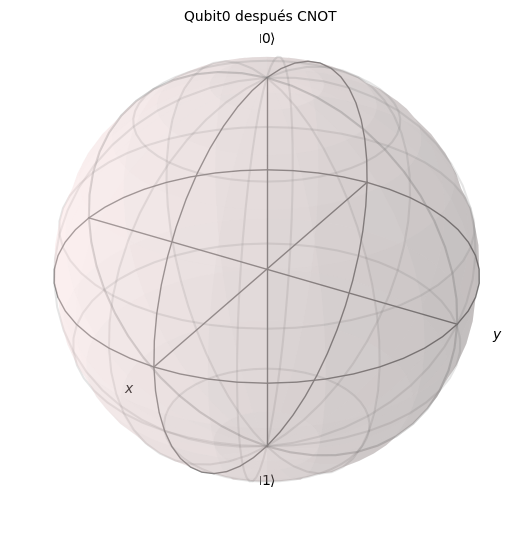

In [ ]:
plot_bloch_vector(bvec_B0, title="Qubit0 después CNOT")

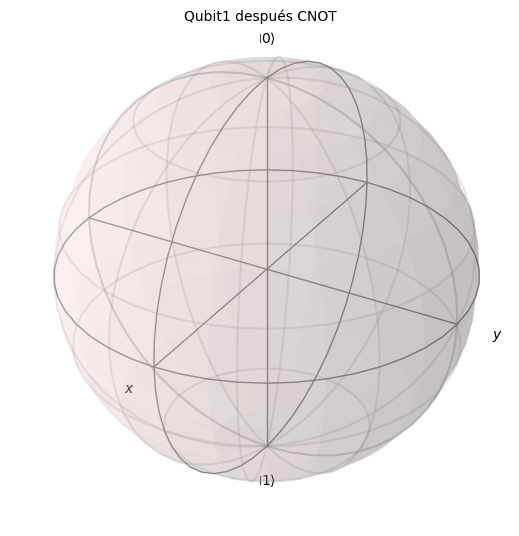

In [ ]:
plot_bloch_vector(bvec_B1, title="Qubit1 después CNOT")